## Prepare surface forcing data for float measurements in the Labrador Sea (1997~1998)

In [1]:
# interactive figure
%matplotlib widget

# auto reload modules
# see https://nocomplexity.com/documents/jupyterlab/tip-autoloadmodule.html
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sca_osbl_tool as sot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl as cmpl
import gsw
from numpy.polynomial import Polynomial as Poly
from sys import platform
from scipy.optimize import curve_fit
from constants import nan, rho0, cp, g, rhoa, pi

%run ../general_scripts/load_font_cmap.py
plt.style.use('../general_scripts/paper.mplstyle') # load figure style

In [2]:
if platform == 'linux':
    GDrive_root = '/media/zhihua/internal1/GDrive/'
elif platform == 'darwin':
    GDrive_root = '/Volumes/GoogleDrive/My Drive/'

labsea_root = GDrive_root + 'UW/Research/Data/LabSea/'
labsea_nbf_dir = labsea_root + 'NBF/'
flux_dir = labsea_root + 'Met/'
outfig_dir = '/home/zhihua/Projects/VTKE_scaling/Figures/'

### Float data

In [3]:
Env97 = xr.open_dataset(labsea_nbf_dir+'LabSea_env_1997.nc').load()
Env97.close()

Env98 = xr.open_dataset(labsea_nbf_dir+'LabSea_env_1998.nc').load()
Env98.close()

ElonC = (Env97.lon.max() + Env98.lon.min())/2
ElatC = (Env97.lat.max() + Env98.lat.min())/2
hdlon = np.ceil((Env97.lon.max() - Env98.lon.min())/2*5)/5
hdlat = np.ceil((Env97.lat.max() - Env98.lat.min())/2)

ElonMin = ElonC - hdlon#-55.7
ElonMax = ElonC + hdlon#-52.3
ElatMin = ElatC - hdlat#56.4
ElatMax = ElatC + hdlat#58.6

### Shipboard meteorological data

In [4]:
Ship97 = xr.open_dataset(flux_dir+'Ship_Knorr/dataset1_crt.cdf').load()
Ship97.close()

Ship97.update({'lon': Ship97.lon.interpolate_na(dim='julian_day', method='linear')})
Ship97.update({'lat': Ship97.lat.interpolate_na(dim='julian_day', method='linear')})
Ship97.update({'slp': Ship97.slp+1.8})
Ship97.update({'shf': -Ship97.shf}) # into the ocean [+]
Ship97.update({'lhf': -Ship97.lhf})

yd97_min = np.floor(Env97.fyd.min())
yd97_max = np.ceil(Env97.fyd.max())
Ship97 = Ship97.sel(julian_day=slice(yd97_min, yd97_max))
Ship97 = Ship97.assign(thf=Ship97.shf+Ship97.lhf)

Ship97 = Ship97.rename_dims({'julian_day': 'time'})
timeShip97 = sot.yd2pytime(Ship97.julian_day, 1997)
Ship97 = Ship97.assign_coords({'time': ('time', timeShip97 + pd.Timedelta(minutes=2.5))})

Ship97hr = Ship97.resample(time='60min', base=30, loffset=pd.Timedelta(minutes=30)).mean(keep_attrs=True, skipna=False)
Ship97hr = Ship97hr.assign(nlw=Ship97hr.lwd-Ship97hr.lwu)
Ship97hr = Ship97hr.assign(nsw=Ship97hr.swd-Ship97hr.swu)
Ship97hr = Ship97hr.assign(thf=Ship97hr.shf+Ship97hr.lhf)
Ship97hr = Ship97hr.assign(hfC3=Ship97hr.nsw+Ship97hr.nlw+Ship97hr.shfC3+Ship97hr.lhfC3)
Ship97hr = Ship97hr.assign_coords({'yd': ('time', sot.pytime2yd(Ship97hr.time))})

windgap97 = Ship97hr.rw.isnull()
nearF97 = ((Ship97hr.lon >= ElonMin) & (Ship97hr.lon <= ElonMax)) & \
          ((Ship97hr.lat >= ElatMin) & (Ship97hr.lat <= ElatMax))

In [5]:
Ship98 = xr.open_dataset(flux_dir+'/Ship_Knorr/dataset2_crt.cdf').load()
Ship98.close()

Ship98.update({'lon': Ship98.lon.interpolate_na(dim='julian_day', method='linear')})
Ship98.update({'lat': Ship98.lat.interpolate_na(dim='julian_day', method='linear')})
Ship98.update({'slp': Ship98.slp+1.8})
Ship98.update({'shf': -Ship98.shf}) # into the ocean [+]
Ship98.update({'lhf': -Ship98.lhf})

yd98_min = np.floor(Env98.fyd.min())
yd98_max = np.ceil(Env98.fyd.max())
Ship98 = Ship98.sel(julian_day=slice(yd98_min, yd98_max))
Ship98 = Ship98.assign(thf=Ship98.shf+Ship98.lhf)

Ship98 = Ship98.rename_dims({'julian_day': 'time'})
timeShip98 = sot.yd2pytime(Ship98.julian_day, 1998)
Ship98 = Ship98.assign_coords({'time': ('time', timeShip98 + pd.Timedelta(minutes=2.5))})

Ship98hr = Ship98.resample(time='60min', base=30, loffset=pd.Timedelta(minutes=30)).mean(keep_attrs=True, skipna=False)
Ship98hr = Ship98hr.assign(nlw=Ship98hr.lwd-Ship98hr.lwu)
Ship98hr = Ship98hr.assign(nsw=Ship98hr.swd-Ship98hr.swu)
Ship98hr = Ship98hr.assign(thf=Ship98hr.shf+Ship98hr.lhf)
Ship98hr = Ship98hr.assign(hfC3=Ship98hr.nsw+Ship98hr.nlw+Ship98hr.shfC3+Ship98hr.lhfC3)
Ship98hr = Ship98hr.assign_coords({'yd': ('time', sot.pytime2yd(Ship98hr.time))})

swgap98 = Ship98hr.yd <= 28.1181
nearF98 = ((Ship98hr.lon >= ElonMin) & (Ship98hr.lon <= ElonMax)) & \
          ((Ship98hr.lat >= ElatMin) & (Ship98hr.lat <= ElatMax))

### JRA55 reanalysis data

In [6]:
JRA55 = xr.open_mfdataset(labsea_root+'Reanalysis/JRA55/1997/*.nc', data_vars='all').load()
JRA55.close()
JRA55 = JRA55.stack(time=['initial_time0_hours', 'forecast_time1'])
JRA55 = JRA55.assign_coords({'time': ('time', [mi[0]+mi[1]-pd.Timedelta(minutes=90) for mi in JRA55.time.values])})
JRA55 = JRA55.rename({'g4_lat_2': 'lat', 'g4_lon_3': 'lon', 'PRES_GDS4_SFC_ave3h': 'sp', 
                      'DLWRF_GDS4_SFC_ave3h': 'lwd', 'DSWRF_GDS4_SFC_ave3h': 'swd', 
                      'ULWRF_GDS4_SFC_ave3h': 'lwu', 'USWRF_GDS4_SFC_ave3h': 'swu',
                      'LHTFL_GDS4_SFC_ave3h': 'lhf', 'SHTFL_GDS4_SFC_ave3h': 'shf',
                      'UFLX_GDS4_SFC_ave3h': 'taux', 'VFLX_GDS4_SFC_ave3h': 'tauy',
                      'EVP_GDS4_SFC_ave3h': 'evap', 'TPRAT_GDS4_SFC_ave3h': 'rain'})
JRA55 = JRA55.assign(lon=JRA55.lon-360)
JRA55 = JRA55.assign(shf=-JRA55.shf)
JRA55 = JRA55.assign(lhf=-JRA55.lhf)
JRA55 = JRA55.assign(emp=(JRA55.evap-JRA55.rain)/24/3600)

Jship97 = JRA55.interp(lon=Ship97hr.lon, lat=Ship97hr.lat, time=Ship97hr.time)
Jship97 = Jship97.assign(tau=np.sqrt(Jship97.taux**2 + Jship97.tauy**2))
Jship97 = Jship97.assign(nsw=Jship97.swd-Jship97.swu)
Jship97 = Jship97.assign(nlw=Jship97.lwd-Jship97.lwu)

In [7]:
JRA55 = xr.open_mfdataset(labsea_root+'Reanalysis/JRA55/1998/*.nc', data_vars='all').load()
JRA55.close()
JRA55 = JRA55.stack(time=['initial_time0_hours', 'forecast_time1'])
JRA55 = JRA55.assign_coords({'time': ('time', [mi[0]+mi[1]-pd.Timedelta(minutes=90) for mi in JRA55.time.values])})
JRA55 = JRA55.rename({'g4_lat_2': 'lat', 'g4_lon_3': 'lon', 'PRES_GDS4_SFC_ave3h': 'sp', 
                      'DLWRF_GDS4_SFC_ave3h': 'lwd', 'DSWRF_GDS4_SFC_ave3h': 'swd', 
                      'ULWRF_GDS4_SFC_ave3h': 'lwu', 'USWRF_GDS4_SFC_ave3h': 'swu',
                      'LHTFL_GDS4_SFC_ave3h': 'lhf', 'SHTFL_GDS4_SFC_ave3h': 'shf',
                      'UFLX_GDS4_SFC_ave3h': 'taux', 'VFLX_GDS4_SFC_ave3h': 'tauy',
                      'EVP_GDS4_SFC_ave3h': 'evap', 'TPRAT_GDS4_SFC_ave3h': 'rain'})
JRA55 = JRA55.assign(lon=JRA55.lon-360)
JRA55 = JRA55.assign(shf=-JRA55.shf)
JRA55 = JRA55.assign(lhf=-JRA55.lhf)
JRA55 = JRA55.assign(emp=(JRA55.evap-JRA55.rain)/24/3600)

Jship98 = JRA55.interp(lon=Ship98hr.lon, lat=Ship98hr.lat, time=Ship98hr.time)
Jship98 = Jship98.assign(tau=np.sqrt(Jship98.taux**2 + Jship98.tauy**2))
Jship98 = Jship98.assign(nsw=Jship98.swd-Jship98.swu)
Jship98 = Jship98.assign(nlw=Jship98.lwd-Jship98.lwu)

### ERA5 reanalysis data

In [6]:
ERA5 = xr.open_dataset(labsea_root+'Reanalysis/ERA5/labsea_surface_hourly_JFM1997-1998.nc').load()
ERA5.close()
# reanalysis mean is over the past hour
ERA5 = ERA5.assign_coords({'time': ('time', ERA5.time.values - pd.Timedelta(minutes=30))})
ERA5 = ERA5.rename({'longitude': 'lon', 'latitude': 'lat'}) #.set_index({'': ''})
ERA5 = ERA5.assign(msthf=ERA5.msshf+ERA5.mslhf)
ERA5 = ERA5.assign(sst=ERA5.sst-273.15)
ERA5 = ERA5.assign(t2m=ERA5.t2m-273.15)
# snow melt is usually zero
ERA5 = ERA5.assign(memp=(-ERA5.mer-ERA5.mtpr)/rho0) # [m/s] ERA5 mer is negative/positive for evaporation/condensation
ERA5 = ERA5.assign(mshf=ERA5.msnswrf+ERA5.msnlwrf+ERA5.msthf)

### Interpolate ERA5 to ship position and time

In [7]:
Eship97 = ERA5.interp(lon=Ship97hr.lon, lat=Ship97hr.lat, time=Ship97hr.time)
Eship97 = Eship97.assign(tau=np.sqrt(Eship97.metss**2 + Eship97.mntss**2))
Eship97 = Eship97.assign(wspd10=np.sqrt(Eship97.u10**2 + Eship97.v10**2))
Eship97 = Eship97.assign(rh2m=sot.rh_from_dewpoint(Eship97.d2m,Eship97.t2m))
Eship97 = Eship97.assign(mshf=Eship97.msnswrf+Eship97.msnlwrf+Eship97.msthf)

Eship98 = ERA5.interp(lon=Ship98hr.lon, lat=Ship98hr.lat, time=Ship98hr.time)
Eship98 = Eship98.assign(tau=np.sqrt(Eship98.metss**2 + Eship98.mntss**2))
Eship98 = Eship98.assign(wspd10=np.sqrt(Eship98.u10**2 + Eship98.v10**2))
Eship98 = Eship98.assign(rh2m=sot.rh_from_dewpoint(Eship98.d2m,Eship98.t2m))
Eship98 = Eship98.assign(mshf=Eship98.msnswrf+Eship98.msnlwrf+Eship98.msthf)

### Interpolate ERA5 to float position and time

In [8]:
varlist = ['metss', 'mntss', 'msshf', 'mslhf', 'msnswrf', 'msnlwrf', 'memp', 'sst', 'sp']

def creat_empty_fmet(idf, timePOS):
    nan_array = np.full((1,timePOS.size), nan)
    return xr.Dataset(data_vars=dict([(var, (('ID','time'), nan_array)) for var in varlist]),
                      coords=dict(ID=('ID', [idf]), time=('time', timePOS.values)))

def interp_ERA5_to_float(Env, ERA5):
    fmet = []
    year = np.unique(Env.fyear)
    for i,idf in enumerate(Env.ID.values):
        iPos = Env[['lon', 'lat']].sel(ID=idf).rename({'timePOS': 'time'})
        if (iPos.lon.notnull().sum() > 1) and (iPos.lat.notnull().sum() > 1):
            last_gps_time = iPos.time.where(iPos.lat.notnull(), drop=True)[-1].data.astype('datetime64[s]')
            print(f'In {int(year)} experiment, float {idf} has GPS track until {last_gps_time}')
            iERA5 = ERA5[varlist].interp(lon=iPos.lon, lat=iPos.lat, time=iPos.time).drop_vars(['lon','lat'])
            fmet.append(iERA5)
        else:
            fmet.append(creat_empty_fmet(idf, Env.timePOS))
    fmet = xr.concat(fmet, dim='ID', combine_attrs='drop').transpose('ID', 'time')
    
    # fill the gap (< 12-hr) near the end with spatial average in neighboring grid cells
    # no_pos = Env.lon.isnull().all(dim='ID')
    # if no_pos.any(): # any time that no float has position?
    #     idx_first_no_pos = np.where(no_pos)[0][0]
    #     idx_last_pos = idx_first_no_pos - 1
    #     idx_ID = np.where(Env.lon[:,idx_last_pos].notnull())[0][0] # only one float has valid position?
    #     lon_interval = [np.floor(Env.lon[idx_ID,idx_last_pos].values), np.ceil(Env.lon[idx_ID,idx_last_pos].values)]
    #     lat_interval = [np.floor(Env.lat[idx_ID,idx_last_pos].values), np.ceil(Env.lat[idx_ID,idx_last_pos].values)]
    #     iERA5 = ERA5.interp(lon=lon_interval, lat=lat_interval, time=Env.timePOS[idx_first_no_pos:].values).mean(dim=['lon','lat'])
    #     for var in varlist:
    #         fmet[var][:,idx_first_no_pos:] = iERA5[var]
    
    # fill gaps with the mean across different floats
    # if year == 1998:
    #     mfmet = fmet.mean('ID')
    #     fmet = fmet.fillna(value=mfmet)
    fmet = fmet.assign(msthf=fmet.msshf+fmet.mslhf)
    fmet = fmet.assign(mtss=np.sqrt(fmet.metss**2 + fmet.mntss**2))
    return fmet

In [9]:
fmet97 = interp_ERA5_to_float(Env97, ERA5)
fmet98 = interp_ERA5_to_float(Env98, ERA5)

In 1997 experiment, float 6.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 8.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 10.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 12.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 14.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 16.0 has GPS track until 1997-03-14T13:00:00
In 1997 experiment, float 17.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 18.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 19.0 has GPS track until 1997-03-01T05:00:00
In 1997 experiment, float 20.0 has GPS track until 1997-02-28T03:00:00
In 1997 experiment, float 21.0 has GPS track until 1997-03-08T01:00:00
In 1998 experiment, float 22.0 has GPS track until 1998-03-12T13:00:00
In 1998 experiment, float 23.0 has GPS track until 1998-03-24T21:00:00
In 1998 experiment, float 26.0 has GPS track until 1998-02-15T23:00:00
In 1998 

### Compare ERA5 with shipboard measurements

#### Time lag check for solar radiation

In [16]:
Eship97_nsw_diurnal = Eship97.msnswrf.groupby(Eship97.time.dt.hour).mean()
Ship97hr_nsw_diurnal = Ship97hr.nsw.groupby(Ship97hr.time.dt.hour).mean()

Eship98_nsw_diurnal = Eship98.msnswrf.groupby(Eship98.time.dt.hour).mean()
Ship98hr_nsw_diurnal = Ship98hr.nsw.groupby(Ship98hr.time.dt.hour).mean()

### Lagged correlation
# pd.DataFrame.from_dict({y: [xr.corr(Eship97[x], Ship97hr[y].shift(time=h)).values \
#    for h in np.arange(-8,9)] for x,y in zip(['msnswrf'],['nsw'])}) \
#    .set_index(np.arange(-8,9))

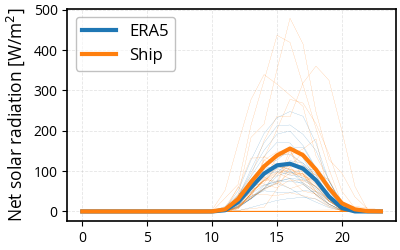

In [17]:
plt.close()
plt.figure(figsize=(4,2.5), constrained_layout=True)

plt.plot(Eship98.time.dt.hour, Eship98.msnswrf, lw=0.1, label='_nolegend_')
plt.plot(Ship98hr.time.dt.hour, Ship98hr.nsw, lw=0.1, label='_nolegend_')
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(0,24), Eship98_nsw_diurnal, lw=3)
plt.plot(np.arange(0,24), Ship98hr_nsw_diurnal,lw=3)
plt.legend(['ERA5', 'Ship'])
plt.ylabel(r'Net solar radiation [W/m$^2$]');

# plt.savefig(outfig_dir + 'labsea97_nsw_diurnal_composite.png');

#### ERA5 wind stress and turbulent heat fluxes are biased high

In [18]:
cice97 = Eship97.siconc > 0
cice98 = Eship98.siconc > 0
# windmatch97 = (Eship97.wspd10-Ship97hr.wspd10) >= -3 #abs(Eship97.wspd10 - Ship97hr.wspd10) <= 3
# windmatch98 = (Eship98.wspd10-Ship98hr.wspd10) >= -3 #abs(Eship98.wspd10 - Ship98hr.wspd10) <= 3
windmatch97 = (Eship97.wspd10-Ship97hr.wspd10).notnull() #abs(Eship97.wspd10 - Ship97hr.wspd10) <= 3
windmatch98 = (Eship98.wspd10-Ship98hr.wspd10).notnull() #abs(Eship98.wspd10 - Ship98hr.wspd10) <= 3

gmask97 = ~cice97 & ~windgap97 & windmatch97 #& nearF97
gmask98 = ~cice98 & windmatch98 #& nearF98

sw_mask97 = ~cice97 #& nearF97
sw_mask98 = ~cice98 & ~swgap98 #& nearF98

##### construct fit for correction

In [21]:
dtau_fit = Poly.fit(xr.concat([Eship97.tau[gmask97], Eship98.tau[gmask98]], dim='time'), 
                    xr.concat([(Eship97.tau-Ship97hr.tauC3)[gmask97], (Eship98.tau-Ship98hr.tauC3)[gmask98]], dim='time'),
                    deg=2)#, domain=[-850,100])
xtau, ytau = dtau_fit.linspace()

dshf_fit = Poly.fit(xr.concat([Eship97.msshf[gmask97], Eship98.msshf[gmask98]], dim='time'),
                    xr.concat([(Eship97.msshf-Ship97hr.shfC3)[gmask97], (Eship98.msshf-Ship98hr.shfC3)[gmask98]], dim='time'),
                    deg=2)#, domain=[0.1,1.3])
xshf, yshf = dshf_fit.linspace()

dlhf_fit = Poly.fit(xr.concat([Eship97.mslhf[gmask97], Eship98.mslhf[gmask98]], dim='time'),
                    xr.concat([(Eship97.mslhf-Ship97hr.lhfC3)[gmask97], (Eship98.mslhf-Ship98hr.lhfC3)[gmask98]], dim='time'),
                    deg=2)#, domain=[0.1,1.3])
xlhf, ylhf = dlhf_fit.linspace()

# dnsw_fit = Poly.fit(xr.concat([Eship97.msnswrf[sw_mask97], Eship98.msnswrf[sw_mask98]], dim='time'),
#                     xr.concat([(Eship97.msnswrf-Ship97hr.nsw)[sw_mask97], (Eship98.msnswrf-Ship98hr.nsw)[sw_mask98]], dim='time'),
#                     deg=1)#, domain=[0.1,1.3])
# xnsw, ynsw = dnsw_fit.linspace()

In [22]:
def ft_linear(x, a, b):
    return np.maximum(a * (x-b), 0)#b=0.22

def linear_ft(x, a, b):
    return np.minimum(a * (x+b), 0)

def hm_linear(x, a):
    return a * x

def etanh(x, a, b, c):
    return 1 + np.tanh(a*(x-b))/c

def hm_quadratic(x, a):
    return a * x**2

def hm_cubic(x, a):
    return a * x**3

In [30]:
ptau = curve_fit(ft_linear, xr.concat([Eship97.tau[gmask97], Eship98.tau[gmask98]], dim='time'),
                 xr.concat([(Eship97.tau-Ship97hr.tauC3)[gmask97], (Eship98.tau-Ship98hr.tauC3)[gmask98]], dim='time'))[0]
ptau97 = curve_fit(ft_linear, Eship97.tau[gmask97], (Eship97.tau-Ship97hr.tauC3)[gmask97])[0]
ptau98 = curve_fit(ft_linear, Eship98.tau[gmask98], (Eship98.tau-Ship98hr.tauC3)[gmask98])[0]

pshf = curve_fit(linear_ft, xr.concat([Eship97.msshf[gmask97], Eship98.msshf[gmask98]], dim='time'), 
                 xr.concat([(Eship97.msshf-Ship97hr.shfC3)[gmask97], (Eship98.msshf-Ship98hr.shfC3)[gmask98]], dim='time'))[0]
pshf97 = curve_fit(linear_ft, Eship97.msshf[gmask97], (Eship97.msshf-Ship97hr.shfC3)[gmask97])[0]
pshf98 = curve_fit(linear_ft, Eship98.msshf[gmask98], (Eship98.msshf-Ship98hr.shfC3)[gmask98])[0]

plhf = curve_fit(linear_ft, xr.concat([Eship97.mslhf[gmask97], Eship98.mslhf[gmask98]], dim='time'), 
                 xr.concat([(Eship97.mslhf-Ship97hr.lhfC3)[gmask97], (Eship98.mslhf-Ship98hr.lhfC3)[gmask98]], dim='time'))[0]
plhf97 = curve_fit(linear_ft, Eship97.mslhf[gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[gmask97])[0]
plhf98 = curve_fit(linear_ft, Eship98.mslhf[gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[gmask98])[0]

# pnsw97 = curve_fit(hm_linear, Eship97.msnswrf[sw_mask97], (Eship97.msnswrf-Ship97hr.nsw)[sw_mask97])[0]
# pnsw98 = curve_fit(hm_linear, Eship98.msnswrf[sw_mask98], (Eship98.msnswrf-Ship98hr.nsw)[sw_mask98])[0]

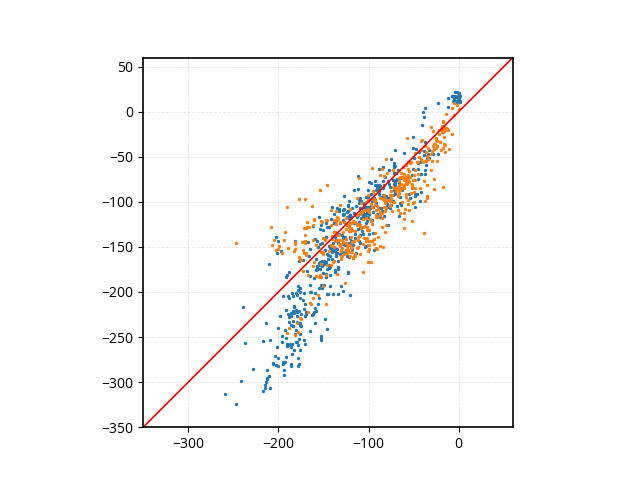

In [16]:
plt.close()

# _,ax = plt.subplots(3,1, figsize=(8,4), constrained_layout=True)
# ax[0].plot(Ship97hr.time, (Ship97hr.at-Ship97hr.sst))
# ax[0].plot(Eship97.time, (Eship97.t2m-Eship97.sst))
# ax[1].plot(Ship97hr.time, Ship97hr.wspd10)
# ax[1].plot(Eship97.time, Eship97.wspd10)
# ax[2].plot(Ship97hr.time, Ship97hr.shfC3)
# ax[2].plot(Eship97.time, Eship97.msshf);

# ax[0].plot(Ship98hr.time, Ship98hr.tauC3)
# ax[0].plot(Eship98.time, Eship98.tau)
# ax[0].plot(Jship98.time, Jship98.tau);
# ax[1].plot(Ship98hr.time, Ship98hr.shfC3)
# ax[1].plot(Eship98.time, Eship98.msshf)
# ax[1].plot(Jship98.time, Jship98.shf);
# ax[2].plot(Ship98hr.time, Ship98hr.lhfC3)
# ax[2].plot(Eship98.time, Eship98.mslhf)
# ax[2].plot(Jship98.time, Jship98.lhf);

# plt.scatter(Ship97hr.wspd10[gmask97], Eship97.wspd10[gmask97], 8, marker='.');
# plt.scatter(Ship98hr.wspd10[gmask98], Eship98.wspd10[gmask98], 8, marker='.');
# plt.plot([0,20], [0,20], c='r');

plt.figure()
# plt.scatter(Ship97hr.tauC3[gmask97], Eship97.tau[gmask97], 8, marker='.');
# plt.scatter(Ship98hr.tauC3[gmask98], Eship98.tau[gmask98], 8, marker='.');
# plt.plot([0,1.75], [0,1.75], c='r')
# plt.xlim(0, 1.75)
# plt.ylim(0, 1.75)

# plt.scatter(Ship97hr.wspd10, (Ship97hr.tauC3/rhoa/(Ship97hr.wspd10**2))*1e3, 5, marker='.');
# plt.scatter(Eship97.wspd10, (Eship97.tau/rhoa/(Eship97.wspd10**2))*1e3, 5, marker='.');

# plt.scatter(Ship97hr.shfC3[gmask97], Jship97.msshf[gmask97], 8, marker='.');
# plt.scatter(Ship98hr.shfC3[gmask98], Jship98.msshf[gmask98], 8, marker='.');
# plt.plot([-550,60], [-550,60], c='r')
# plt.xlim(-550,60)
# plt.ylim(-550,60)

plt.scatter(Ship97hr.lhfC3[gmask97], Eship97.mslhf[gmask97], 8, marker='.');
plt.scatter(Ship98hr.lhfC3[gmask98], Eship98.mslhf[gmask98], 8, marker='.');
plt.plot([-350,60], [-350,60], c='r')
plt.xlim(-350,60)
plt.ylim(-350,60)

plt.gca().set_aspect('equal', adjustable='box');

#### test 1, self correction

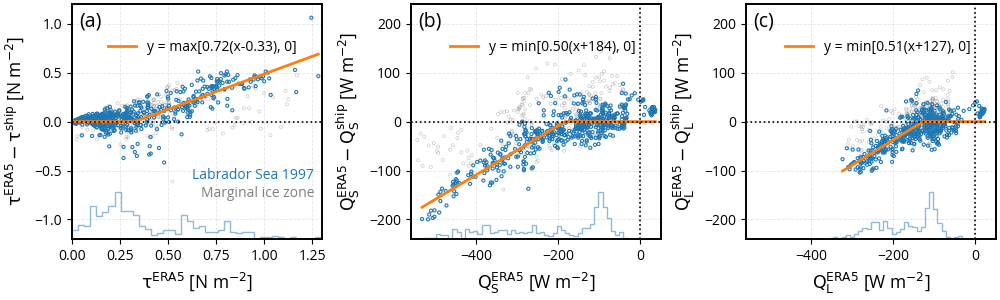

In [25]:
plt.close()
fig = plt.figure(figsize=(10,3), constrained_layout=True)
spec = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(Eship97.tau[~gmask97], (Eship97.tau-Ship97hr.tauC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.4)
# ax1.scatter(Eship98.tau[~gmask98], (Eship98.tau-Ship98hr.tauC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax1.scatter(Eship97.tau[gmask97], (Eship97.tau-Ship97hr.tauC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
# ax1.scatter(Eship98.tau[gmask98], (Eship98.tau-Ship98hr.tauC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
lfit97, = ax1.plot(xtau, ft_linear(xtau, *ptau97), 'C1', lw=2)
# lfit98, = ax1.plot(xtau, ft_linear(xtau, *ptau98), 'C1', lw=2)
# ax1.plot(xtau, ft_linear(xtau, *ptau), '--k', lw=2)
# ax1.plot(xtau, ytau, '--r', lw=2)
ax1.axhline(0, c='k', ls=':')
ax1.axvline(0, c='k', ls=':')
ax1.set_xlim(0,1.3)
ax1.set_ylim(-1.2,1.2)
ax1.text(0.03, 0.97, '(a)', transform=ax1.transAxes, fontsize=14, ha='left', va='top')
# ax1.legend([lfit97,lfit98], [f'y = max[{ptau97[0]:.2f}(x-0.22), 0]', f'y = max[{ptau98[0]:.2f}(x-0.22), 0]'], 
#            fontsize=10, loc='upper right', bbox_to_anchor=(0.97, 1.02), frameon=False)
ax1.legend([lfit97], [f'y = max[{ptau97[0]:.2f}(x-{ptau97[1]:.2f}), 0]'], 
           fontsize=10, loc='upper right', bbox_to_anchor=(0.95, 0.9), frameon=False)
ax1.text(0.97, 0.24, 'Labrador Sea 1997', c='C0', transform=ax1.transAxes, fontsize=10, ha='right', va='bottom')
# ax1.text(0.97, 0.17, 'Labrador Sea 1998', c='C1', transform=ax1.transAxes, fontsize=10, ha='right', va='bottom')
ax1.text(0.97, 0.16, 'Marginal ice zone', c='gray', transform=ax1.transAxes, fontsize=10, ha='right', va='bottom')
ax1.set_xlabel(r'$\tau^{ERA5}$ [N m$^{-2}$]')
ax1.set_ylabel(r'$\tau^{ERA5} - \tau^{ship}$ [N m$^{-2}$]')
ax1r = ax1.twinx()
pdf97,_,_ = ax1r.hist(np.ravel(fmet97.mtss), 60, histtype='step', alpha=0.5, density=True)
# pdf98,_,_ = ax1r.hist(np.ravel(fmet98.mtss), 60, histtype='step', alpha=0.5, density=True)
ax1r.set_ylim(0, 5*np.max([pdf97]))#, pdf98]))
ax1r.tick_params(axis='y', right=False, labelright=False)
ax1r.grid(False)

ax2 = fig.add_subplot(spec[0, 1])
ax2.scatter(Eship97.msshf[~gmask97], (Eship97.msshf-Ship97hr.shfC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.4)
# ax2.scatter(Eship98.msshf[~gmask98], (Eship98.msshf-Ship98hr.shfC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax2.scatter(Eship97.msshf[gmask97], (Eship97.msshf-Ship97hr.shfC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
# ax2.scatter(Eship98.msshf[gmask98], (Eship98.msshf-Ship98hr.shfC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
lfit97, = ax2.plot(xshf, linear_ft(xshf, *pshf97), 'C1', lw=2)
# lfit98, = ax2.plot(xshf, linear_ft(xshf, *pshf98), 'C1', lw=2)
# ax2.plot(xshf, linear_ft(xshf, *pshf), '--k', lw=2)
# ax2.plot(xshf, yshf, '--r', lw=2)
ax2.axhline(0, c='k', ls=':')
ax2.axvline(0, c='k', ls=':')
ax2.set_ylim(-240,240)
ax2.set_xlim(-560,50)
ax2.text(0.03, 0.97, '(b)', transform=ax2.transAxes, fontsize=14, ha='left', va='top')
# ax2.legend([lfit97, lfit98], [f'y = {pshf97[0]:.5f} $x^2$', f'y = {pshf98[0]:.5f} $x^2$'], 
#            fontsize=10, loc='upper right', bbox_to_anchor=(0.95, 1.02), frameon=False)
ax2.legend([lfit97], [f'y = min[{pshf97[0]:.2f}(x+{pshf97[1]:.0f}), 0]'], 
           fontsize=10, loc='upper right', bbox_to_anchor=(0.95, 0.9), frameon=False)
ax2.set_xlabel(r'$Q^{ERA5}_{S}$ [W m$^{-2}$]')
ax2.set_ylabel(r'$Q^{ERA5}_{S} - Q^{ship}_{S}$ [W m$^{-2}$]')
ax2r = ax2.twinx()
pdf97,_,_ = ax2r.hist(np.ravel(fmet97.msshf), 60, histtype='step', alpha=0.5, density=True, range=(-560,50))
# pdf98,_,_ = ax2r.hist(np.ravel(fmet98.msshf), 60, histtype='step', alpha=0.5, density=True)
ax2r.set_ylim(0, 5*np.max([pdf97]))#, pdf98]))
ax2r.tick_params(axis='y', right=False, labelright=False)
ax2r.grid(False)

ax3 = fig.add_subplot(spec[0, 2])
ax3.scatter(Eship97.mslhf[~gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.4)
# ax3.scatter(Eship98.mslhf[~gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax3.scatter(Eship97.mslhf[gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
# ax3.scatter(Eship98.mslhf[gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
lfit97, = ax3.plot(xlhf, linear_ft(xlhf, *plhf97), 'C1', lw=2)
# lfit98, = ax3.plot(xlhf, linear_ft(xlhf, *plhf98), 'C1', lw=2)
# ax3.plot(xlhf, linear_ft(xlhf, *plhf), '--k', lw=2)
# ax3.plot(xlhf, ylhf, '--r', lw=2)
ax3.axhline(0, c='k', ls=':')
ax3.axvline(0, c='k', ls=':')
ax3.set_ylim(-240,240)
ax3.set_xlim(-560,50)
ax3.text(0.03, 0.97, '(c)', transform=ax3.transAxes, fontsize=14, ha='left', va='top')
# ax3.legend([lfit97, lfit98], [f'y = {plhf97[0]:.5f} $x^2$', f'y = {plhf98[0]:.5f} $x^2$'], 
#            fontsize=10, loc='upper right', bbox_to_anchor=(0.95, 1.02), frameon=False)
ax3.legend([lfit97], [f'y = min[{plhf97[0]:.2f}(x+{plhf97[1]:.0f}), 0]'], 
           fontsize=10, loc='upper right', bbox_to_anchor=(0.95, 0.9), frameon=False)
ax3.set_xlabel(r'$Q^{ERA5}_{L}$ [W m$^{-2}$]')
ax3.set_ylabel(r'$Q^{ERA5}_{L} - Q^{ship}_{L}$ [W m$^{-2}$]');
ax3r = ax3.twinx()
pdf97,_,_ = ax3r.hist(np.ravel(fmet97.mslhf), 60, histtype='step', alpha=0.5, density=True, range=(-560,50))
# pdf98,_,_ = ax3r.hist(np.ravel(fmet98.mslhf), 60, histtype='step', alpha=0.5, density=True)
ax3r.set_ylim(0, 5*np.max([pdf97]))#, pdf98]))
ax3r.tick_params(axis='y', right=False, labelright=False)
ax3r.grid(False)

# ax4 = fig.add_subplot(spec[0, 3])
# ax4.scatter(Ship97hr.nsw[~sw_mask97], (Eship97.msnswrf-Ship97hr.nsw)[~sw_mask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
# # ax4.scatter(Ship98hr.nsw[~sw_mask98], (Eship98.msnswrf-Ship98hr.nsw)[~sw_mask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
# ax4.scatter(Ship97hr.nsw[sw_mask97], (Eship97.msnswrf-Ship97hr.nsw)[sw_mask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
# # ax4.scatter(Ship98hr.nsw[sw_mask98], (Eship98.msnswrf-Ship98hr.nsw)[sw_mask98], 5, facecolor='none', edgecolors='C1', lw=0.8);
# ax4.plot(xnsw, hm_linear(xnsw, *pnsw97), 'C0', lw=2)
# # ax4.plot(xnsw, hm_linear(xnsw, *pnsw98), 'C1', lw=2)

# plt.savefig(outfig_dir + 'labsea97_turbfluxes_self_correction.png');

#### test 2, correction based on wind

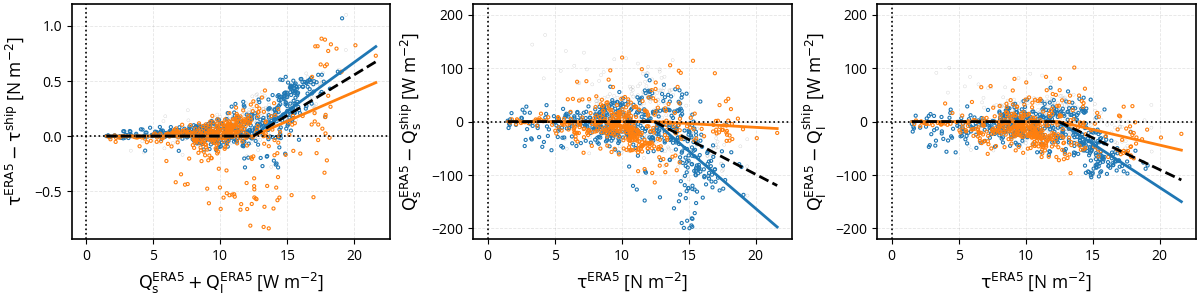

In [103]:
plt.close()
fig = plt.figure(figsize=(12,3), constrained_layout=True)
spec = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(Eship97.wspd10[~gmask97], (Eship97.tau-Ship97hr.tau)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax1.scatter(Eship98.wspd10[~gmask98], (Eship98.tau-Ship98hr.tauC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax1.scatter(Eship97.wspd10[gmask97], (Eship97.tau-Ship97hr.tau)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax1.scatter(Eship98.wspd10[gmask98], (Eship98.tau-Ship98hr.tauC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
ax1.plot(xtau, hm_linear(xtau, *ptau97), 'C0', lw=2)
ax1.plot(xtau, hm_linear(xtau, *ptau98), 'C1', lw=2)
ax1.plot(xtau, hm_linear(xtau, *ptau), '--k', lw=2)
# ax1.plot(xtau, ytau, '--r', lw=2)
ax1.axhline(0, c='k', ls=':')
ax1.axvline(0, c='k', ls=':')
# ax1.set_xlim(-900,100)
# ax1.set_ylim(-1.2,1.2)
ax1.set_xlabel(r'$Q^{ERA5}_{s} + Q^{ERA5}_{l}$ [W m$^{-2}$]')
ax1.set_ylabel(r'$\tau^{ERA5} - \tau^{ship}$ [N m$^{-2}$]')
# ax1r = ax1.twinx()
# ax1r.hist(np.ravel(fmet97.msthf), 60, histtype='step', alpha=0.5)
# ax1r.hist(np.ravel(fmet98.msthf), 60, histtype='step', alpha=0.5)
# ax1r.set_ylim(0,3200)
# ax1r.grid(False)

ax2 = fig.add_subplot(spec[0, 1])
ax2.scatter(Eship97.wspd10[~gmask97], (Eship97.msshf-Ship97hr.shfC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax2.scatter(Eship98.wspd10[~gmask98], (Eship98.msshf-Ship98hr.shfC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax2.scatter(Eship97.wspd10[gmask97], (Eship97.msshf-Ship97hr.shfC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax2.scatter(Eship98.wspd10[gmask98], (Eship98.msshf-Ship98hr.shfC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
ax2.plot(xshf, hm_linear(xshf, *pshf97), 'C0', lw=2)
ax2.plot(xshf, hm_linear(xshf, *pshf98), 'C1', lw=2)
ax2.plot(xshf, hm_linear(xshf, *pshf), '--k', lw=2)
# ax2.plot(xshf, yshf, '--r', lw=2)
ax2.axhline(0, c='k', ls=':')
ax2.axvline(0, c='k', ls=':')
ax2.set_ylim(-220,220)
# ax2.set_xlim(-0.05,1.3)
ax2.set_xlabel(r'$\tau^{ERA5}$ [N m$^{-2}$]')
ax2.set_ylabel(r'$Q^{ERA5}_{s} - Q^{ship}_{s}$ [W m$^{-2}$]')

ax3 = fig.add_subplot(spec[0, 2])
ax3.scatter(Eship97.wspd10[~gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax3.scatter(Eship98.wspd10[~gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax3.scatter(Eship97.wspd10[gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax3.scatter(Eship98.wspd10[gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
ax3.plot(xlhf, hm_linear(xlhf, *plhf97), 'C0', lw=2)
ax3.plot(xlhf, hm_linear(xlhf, *plhf98), 'C1', lw=2)
ax3.plot(xlhf, hm_linear(xlhf, *plhf), '--k', lw=2)
# ax3.plot(xlhf, ylhf, '--r', lw=2)
ax3.axhline(0, c='k', ls=':')
ax3.axvline(0, c='k', ls=':')
ax3.set_ylim(-220,220)
# ax3.set_xlim(-0.05,1.3)
ax3.set_xlabel(r'$\tau^{ERA5}$ [N m$^{-2}$]')
ax3.set_ylabel(r'$Q^{ERA5}_{l} - Q^{ship}_{l}$ [W m$^{-2}$]');
# ax3r = ax3.twinx()
# ax3r.hist(np.ravel(fmet97.mtss), 60, histtype='step', alpha=0.5)
# ax3r.hist(np.ravel(fmet98.mtss), 60, histtype='step', alpha=0.5)
# ax3r.set_ylim(0,3200)
# ax3r.grid(False)

# plt.savefig(outfig_dir + 'labsea_turbfluxes_correction.png');

#### cross correction

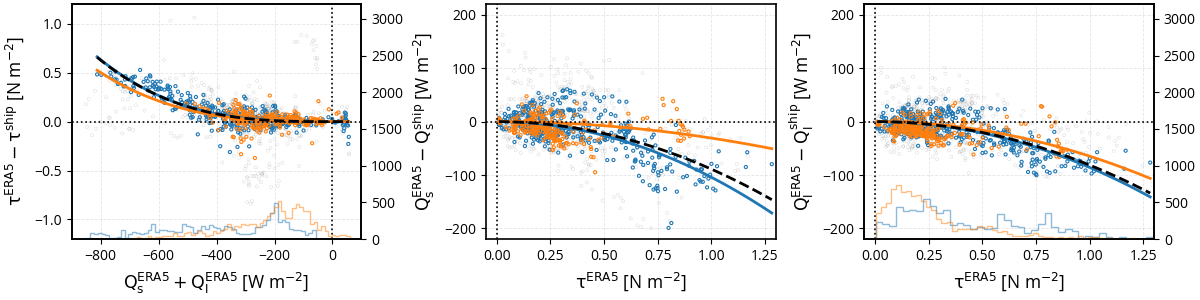

In [37]:
plt.close()
fig = plt.figure(figsize=(12,3), constrained_layout=True)
spec = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(Eship97.msthf[~gmask97], (Eship97.tau-Ship97hr.tauC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax1.scatter(Eship98.msthf[~gmask98], (Eship98.tau-Ship98hr.tauC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax1.scatter(Eship97.msthf[gmask97], (Eship97.tau-Ship97hr.tauC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax1.scatter(Eship98.msthf[gmask98], (Eship98.tau-Ship98hr.tauC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
# ax1.plot(xtau, hm_cubic(xtau, *ptau97), 'C0', lw=2)
# ax1.plot(xtau, hm_cubic(xtau, *ptau98), 'C1', lw=2)
# ax1.plot(xtau, hm_cubic(xtau, *ptau), '--k', lw=2)
# ax1.plot(xtau, ytau, '--r', lw=2)
ax1.axhline(0, c='k', ls=':')
ax1.axvline(0, c='k', ls=':')
ax1.set_xlim(-900,100)
ax1.set_ylim(-1.2,1.2)
ax1.set_xlabel(r'$Q^{ERA5}_{s} + Q^{ERA5}_{l}$ [W m$^{-2}$]')
ax1.set_ylabel(r'$\tau^{ERA5} - \tau^{ship}$ [N m$^{-2}$]')
ax1r = ax1.twinx()
ax1r.hist(np.ravel(fmet97.msthf), 60, histtype='step', alpha=0.5)
ax1r.hist(np.ravel(fmet98.msthf), 60, histtype='step', alpha=0.5)
ax1r.set_ylim(0,3200)
ax1r.grid(False)

ax2 = fig.add_subplot(spec[0, 1])
ax2.scatter(Eship97.tau[~gmask97], (Eship97.msshf-Ship97hr.shfC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax2.scatter(Eship98.tau[~gmask98], (Eship98.msshf-Ship98hr.shfC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax2.scatter(Eship97.tau[gmask97], (Eship97.msshf-Ship97hr.shfC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax2.scatter(Eship98.tau[gmask98], (Eship98.msshf-Ship98hr.shfC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
# ax2.plot(xshf, hm_quadratic(xshf, *pshf97), 'C0', lw=2)
# ax2.plot(xshf, hm_quadratic(xshf, *pshf98), 'C1', lw=2)
# ax2.plot(xshf, hm_quadratic(xshf, *pshf), '--k', lw=2)
# ax2.plot(xshf, yshf, '--r', lw=2)
ax2.axhline(0, c='k', ls=':')
ax2.axvline(0, c='k', ls=':')
ax2.set_ylim(-220,220)
ax2.set_xlim(-0.05,1.3)
ax2.set_xlabel(r'$\tau^{ERA5}$ [N m$^{-2}$]')
ax2.set_ylabel(r'$Q^{ERA5}_{s} - Q^{ship}_{s}$ [W m$^{-2}$]')

ax3 = fig.add_subplot(spec[0, 2])
ax3.scatter(Eship97.tau[~gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[~gmask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax3.scatter(Eship98.tau[~gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[~gmask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax3.scatter(Eship97.tau[gmask97], (Eship97.mslhf-Ship97hr.lhfC3)[gmask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax3.scatter(Eship98.tau[gmask98], (Eship98.mslhf-Ship98hr.lhfC3)[gmask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
# ax3.plot(xlhf, hm_quadratic(xlhf, *plhf97), 'C0', lw=2)
# ax3.plot(xlhf, hm_quadratic(xlhf, *plhf98), 'C1', lw=2)
# ax3.plot(xlhf, hm_quadratic(xlhf, *plhf), '--k', lw=2)
# ax3.plot(xlhf, ylhf, '--r', lw=2)
ax3.axhline(0, c='k', ls=':')
ax3.axvline(0, c='k', ls=':')
ax3.set_ylim(-220,220)
ax3.set_xlim(-0.05,1.3)
ax3.set_xlabel(r'$\tau^{ERA5}$ [N m$^{-2}$]')
ax3.set_ylabel(r'$Q^{ERA5}_{l} - Q^{ship}_{l}$ [W m$^{-2}$]');
ax3r = ax3.twinx()
ax3r.hist(np.ravel(fmet97.mtss), 60, histtype='step', alpha=0.5)
ax3r.hist(np.ravel(fmet98.mtss), 60, histtype='step', alpha=0.5)
ax3r.set_ylim(0,3200)
ax3r.grid(False)

# plt.savefig(outfig_dir + 'labsea_turbfluxes_correction.png');

#### ERA5 net solar radiation is baised high, but net longwave radiation seems fine

In [34]:
psw97

1.6999687408255921

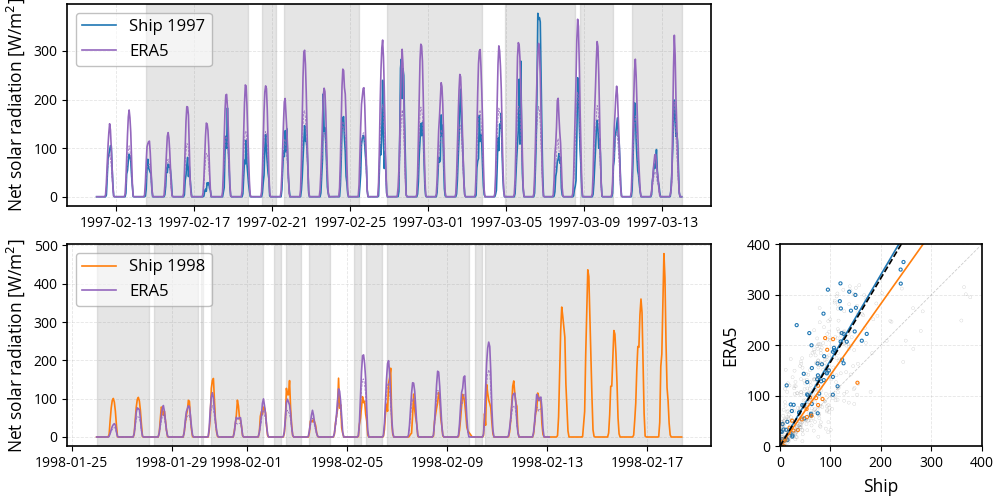

In [33]:
sw_mask97 = nearF97 & ~cice97
sw_mask98 = nearF98 & ~cice98 & ~swgap98

plt.close()
fig = plt.figure(figsize=(10,5), constrained_layout=True)
spec = fig.add_gridspec(2, 4)
psw = np.linalg.lstsq(np.hstack([Ship97hr.nsw[sw_mask97], Ship98hr.nsw[sw_mask98]])[:,None],
                      np.hstack([Eship97.msnswrf[sw_mask97], Eship98.msnswrf[sw_mask98]]), rcond=None)[0][0]
psw97 = np.linalg.lstsq(Ship97hr.nsw[sw_mask97].values[:,None], Eship97.msnswrf[sw_mask97], rcond=None)[0][0]
psw98 = np.linalg.lstsq(Ship98hr.nsw[sw_mask98].values[:,None], Eship98.msnswrf[sw_mask98], rcond=None)[0][0]

ax1 = fig.add_subplot(spec[0, :3])
ax1.plot(Ship97hr.time, Ship97hr.nsw)
ax1.plot(Eship97.time, Eship97.msnswrf, 'C4')
ax1.plot(Eship97.time, Eship97.msnswrf/psw97, 'C4', ls='--', lw=0.5)
# ax1.plot(Jship97.time, Jship97.nsw)
ax1.fill_between(Eship97.time.values, 0, 1, where=~sw_mask97, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.legend(['Ship 1997', 'ERA5']);
ax1.set_ylabel(r'Net solar radiation [W/m$^2$]');

# ax2 = fig.add_subplot(spec[0, 3])
# ax2.scatter(Ship97hr.nsw[sw_mask97], Eship97.msnswrf[sw_mask97], 5, facecolor='none', edgecolors='C0')
# ax2.scatter(Ship97hr.nsw[~sw_mask97], Eship97.msnswrf[~sw_mask97], 5, facecolor='none', edgecolors='gray', alpha=0.4)
# ax2.plot([0, 400], [0, 400], 'k')
# ax2.plot([0, 400], [0, 400*r1], 'r')
# ax2.set_aspect('equal', 'box')
# ax2.set(xlim=(0, 400), ylim=(0, 400))
# ax2.set_ylabel('ERA5')
# ax2.set_xlabel('Ship');

ax3 = fig.add_subplot(spec[1, :3])
ax3.plot(Ship98hr.time, Ship98hr.nsw, 'C1')
ax3.plot(Eship98.time, Eship98.msnswrf, 'C4')
ax3.plot(Eship98.time, Eship98.msnswrf/psw98, 'C4', ls='--', lw=0.5)
# ax3.plot(Jship98.time, Jship98.nsw)
ax3.fill_between(Eship98.time.values, 0, 1, where=~sw_mask98, color='gray', 
                 alpha=0.2, transform=ax3.get_xaxis_transform())
ax3.legend(['Ship 1998', 'ERA5']);
ax3.set_ylabel(r'Net solar radiation [W/m$^2$]');

ax4 = fig.add_subplot(spec[1, 3])
ax4.scatter(Ship97hr.nsw[sw_mask97], Eship97.msnswrf[sw_mask97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax4.scatter(Ship97hr.nsw[~sw_mask97], Eship97.msnswrf[~sw_mask97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax4.scatter(Ship98hr.nsw[sw_mask98], Eship98.msnswrf[sw_mask98], 5, facecolor='none', edgecolors='C1', lw=0.8)
ax4.scatter(Ship98hr.nsw[~sw_mask98], Eship98.msnswrf[~sw_mask98], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax4.plot([0, 400], [0, 400], 'gray', ls='--', alpha=0.4, lw=0.6)
ax4.plot([0, 400], [0, 400*psw97], 'C0')
ax4.plot([0, 400], [0, 400*psw98], 'C1')
ax4.plot([0, 400], [0, 400*psw], 'k--')
ax4.set_aspect('equal', 'box')
ax4.set(xlim=(0, 400), ylim=(0, 400))
ax4.set_ylabel('ERA5')
ax4.set_xlabel('Ship');

#plt.savefig(outfig_dir + 'labsea_nsw_compare.png');

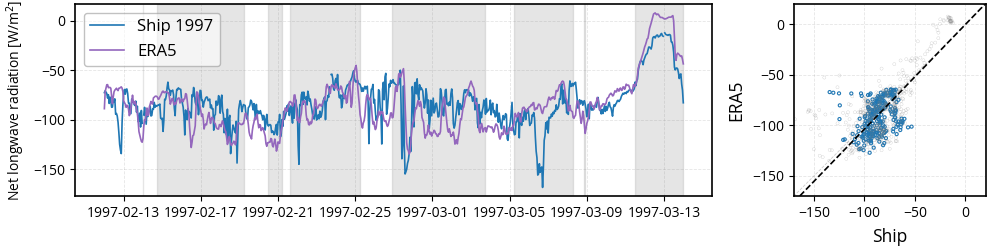

In [30]:
lw_mask97 = nearF97 & ~cice97 & ~np.isnan(Ship97hr.nlw)

plt.close()
fig = plt.figure(figsize=(10,2.5), constrained_layout=True)
spec = fig.add_gridspec(1, 4)
plw = np.linalg.lstsq(Ship97hr.nlw[lw_mask97].values[:,None], Eship97.msnlwrf[lw_mask97], rcond=None)[0][0]

ax1 = fig.add_subplot(spec[0, :3])
ax1.plot(Ship97hr.time, Ship97hr.nlw)
ax1.plot(Eship97.time, Eship97.msnlwrf, 'C4')
# ax1.plot(Jship97.time, Jship97.nlw)
ax1.fill_between(Eship97.time.values, 0, 1, where=~lw_mask97, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.legend(['Ship 1997', 'ERA5']);
ax1.set_ylabel(r'Net longwave radiation [W/m$^2$]', fontsize=10);

ax2 = fig.add_subplot(spec[0, 3])
ax2.scatter(Ship97hr.nlw[nearF97], Eship97.msnlwrf[nearF97], 5, facecolor='none', edgecolors='C0', lw=0.8)
ax2.scatter(Ship97hr.nlw[~nearF97], Eship97.msnlwrf[~nearF97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
ax2.plot([-170, 20], [-170, 20], 'gray', ls='--', alpha=0.4, lw=0.6)
ax2.plot([-170, 20], [-170*plw, 20*plw], 'k--')
ax2.set_aspect('equal', 'box')
ax2.set(xlim=(-170, 20), ylim=(-170, 20))
ax2.set_ylabel('ERA5')
ax2.set_xlabel('Ship');

# ax3 = fig.add_subplot(spec[1, :3])
# ax3.plot(Ship98hr.time, Ship98hr.nlw)
# ax3.plot(Eship98.time, Eship98.msnlwrf)
# ax3.plot(Jship98.time, Jship98.nlw)
# ax3.fill_between(Eship98.time.values, 0, 1, where=~nearF98, color='gray', 
#                  alpha=0.2, transform=ax3.get_xaxis_transform())
# ax3.set_ylabel(r'Net longwave radiation [W/m$^2$]');

# ax4 = fig.add_subplot(spec[1, 3])
# ax4.scatter(Ship97hr.nlw[nearF97], Eship97.msnlwrf[nearF97], 5, facecolor='none', edgecolors='C0')
# ax4.scatter(Ship98hr.nlw[nearF98], Eship98.msnlwrf[nearF98], 5, facecolor='none', edgecolors='C1')
# ax4.scatter(Ship98hr.nlw[~nearF98], Eship98.msnlwrf[~nearF98], 5, facecolor='none', edgecolors='gray', alpha=0.4)
# ax4.plot([-170, 20], [-170, 20], 'k')
# # ax4.plot([-170, 20], [-170*r, 20*r], 'r')
# ax4.set_aspect('equal', 'box')
# ax4.set(xlim=(-170, 20), ylim=(-170, 20))
# ax4.set_ylabel('ERA5')
# ax4.set_xlabel('Ship');

#plt.savefig(outfig_dir + 'labsea_nlw_compare.png');

#### Assess the correction of turbulent fluxes

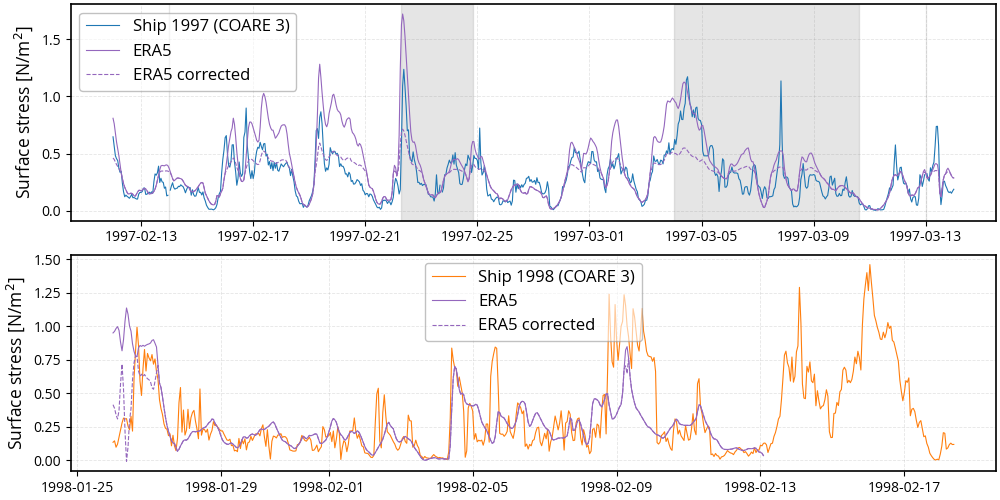

In [54]:
tau_mask97 = ~cice97 & ~windgap97 #nearF97 & 
tau_mask98 = ~cice98 #nearF98 & 

plt.close()
fig = plt.figure(figsize=(10,5), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(spec[0, :])
# ax1.plot(Ship97hr.time, Ship97hr.tau)
ax1.plot(Ship97hr.time, Ship97hr.tauC3, lw=0.8)
ax1.plot(Eship97.time, Eship97.tau, 'C4', lw=0.8)
ax1.plot(Eship97.time, Eship97.tau-ft_linear(Eship97.tau, *ptau97), 'C4', ls='--', lw=0.8)
# ax1.plot(Jship98.time, Jship98.tau)
ax1.fill_between(Eship97.time.values, 0, 1, where=~tau_mask97, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.legend(['Ship 1997 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax1.set_ylabel(r'Surface stress [N/m$^2$]');

# ax2 = fig.add_subplot(spec[0, 3])
# ax2.scatter(Ship97hr.tau[~cice97], Eship97.tau[~cice97], 5, facecolor='none', edgecolors='C0', lw=0.8)
# ax2.scatter(Ship97hr.tauC3[~cice97], Eship97.tau[~cice97], 5, facecolor='none', edgecolors='C1', lw=0.8)
# ax2.scatter(Ship97hr.tauC3[cice97], Eship97.tau[cice97], 5, facecolor='none', edgecolors='gray', alpha=0.5, lw=0.2)
# ax2.plot([0, 1.8], [0 ,1.8], 'k')
# # ax2.plot([0, 1.8], [0 ,1.8*r], 'r')
# ax2.set_aspect('equal', 'box')
# ax2.set(xlim=(-0.02, 1.8), ylim=(-0.02, 1.8))
# ax2.set_ylabel('ERA5')
# ax2.set_xlabel('Ship');

ax3 = fig.add_subplot(spec[1, :])
ax3.plot(Ship98hr.time, Ship98hr.tauC3, 'C1', lw=0.8)
ax3.plot(Eship98.time, Eship98.tau, 'C4', lw=0.8)
ax3.plot(Eship98.time, Eship98.tau-ft_linear(Eship98.tau, *ptau98), 'C4', ls='--', lw=0.8)
# ax1.plot(Jship98.time, Jship98.tau)
ax3.fill_between(Eship98.time.values, 0, 1, where=~tau_mask98, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax3.legend(['Ship 1998 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax3.set_ylabel(r'Surface stress [N/m$^2$]');

#plt.savefig(outfig_dir + 'labsea_tau_compare.png');

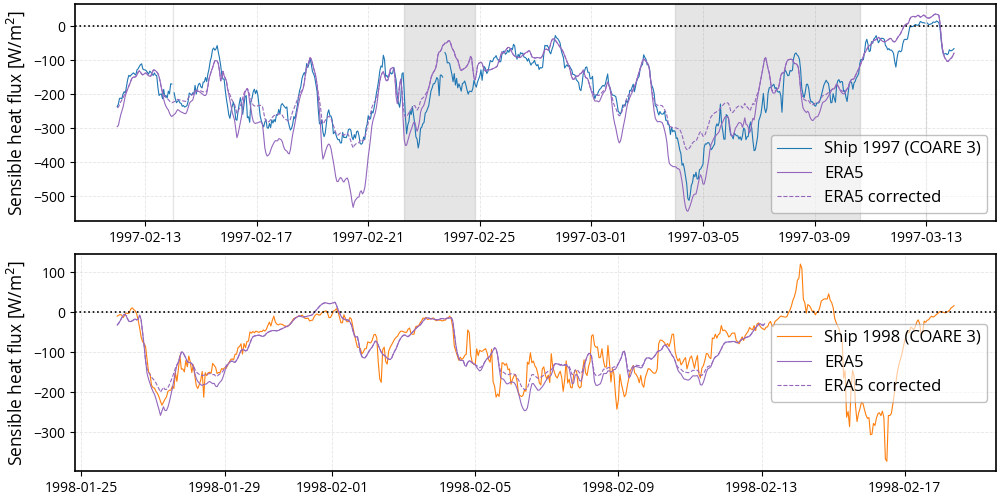

In [55]:
plt.close()
fig = plt.figure(figsize=(10,5), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(spec[0, :])
# ax1.plot(Ship97hr.time, Ship97hr.shf)
ax1.plot(Ship97hr.time, Ship97hr.shfC3, lw=0.8)
ax1.plot(Eship97.time, Eship97.msshf, 'C4', lw=0.8)
ax1.plot(Eship97.time, Eship97.msshf-linear_ft(Eship97.msshf, *pshf97), 'C4', ls='--', lw=0.8)
# ax1.plot(Jship98.time, Jship98.shf)
ax1.fill_between(Eship97.time.values, 0, 1, where=~tau_mask97, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.axhline(0, ls=':', c='k')
ax1.legend(['Ship 1997 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax1.set_ylabel(r'Sensible heat flux [W/m$^2$]');

# ax2 = fig.add_subplot(spec[0, 3])
# ax2.scatter(Ship97hr.shf[~cice97], Eship97.msshf[~cice97], 5, facecolor='none', edgecolors='C0')
# ax2.scatter(Ship97hr.shfC3[~cice97], Eship97.msshf[~cice97], 5, facecolor='none', edgecolors='C1')
# ax2.scatter(Ship97hr.shfC3[cice97], Eship97.msshf[cice97], 5, facecolor='none', edgecolors='gray')
# ax2.plot([-600, 100], [-600, 100], 'k')
# # ax2.plot([-600, 100], [-600*r, 100*r], 'r')
# ax2.axhline(0, ls=':', c='k')
# ax2.axvline(0, ls=':', c='k')
# ax2.set_aspect('equal', 'box')
# ax2.set(xlim=(-600, 100), ylim=(-600, 100))
# ax2.set_ylabel('ERA5')
# ax2.set_xlabel('Ship');

ax3 = fig.add_subplot(spec[1, :])
# ax1.plot(Ship97hr.time, Ship97hr.shf)
ax3.plot(Ship98hr.time, Ship98hr.shfC3, 'C1', lw=0.8)
ax3.plot(Eship98.time, Eship98.msshf, 'C4', lw=0.8)
ax3.plot(Eship98.time, Eship98.msshf-linear_ft(Eship98.msshf, *pshf98), 'C4', ls='--', lw=0.8)
# ax1.plot(Jship98.time, Jship98.shf)
ax3.fill_between(Eship98.time.values, 0, 1, where=~tau_mask98, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax3.axhline(0, ls=':', c='k')
ax3.legend(['Ship 1998 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax3.set_ylabel(r'Sensible heat flux [W/m$^2$]');

#plt.savefig(outfig_dir + 'labsea_shf_compare.png');

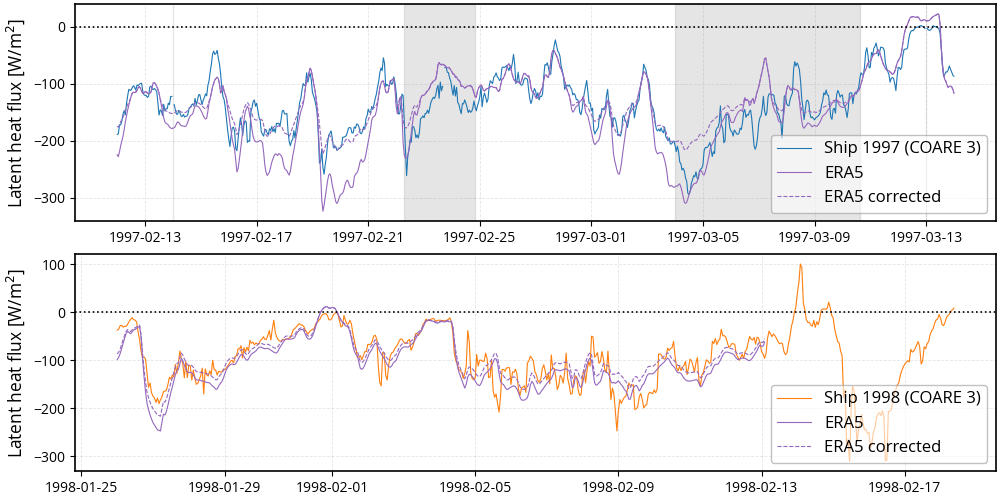

In [57]:
plt.close()
fig = plt.figure(figsize=(10,5), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(spec[0, :])
# ax1.plot(Ship97hr.time, Ship97hr.lhf)
ax1.plot(Ship97hr.time, Ship97hr.lhfC3, lw=0.8)
ax1.plot(Eship97.time, Eship97.mslhf, 'C4', lw=0.8)
ax1.plot(Eship97.time, Eship97.mslhf-linear_ft(Eship97.mslhf, *plhf97), 'C4', ls='--', lw=0.8)
ax1.fill_between(Eship97.time.values, 0, 1, where=~tau_mask97, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.axhline(0, ls=':', c='k')
ax1.legend(['Ship 1997 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax1.set_ylabel(r'Latent heat flux [W/m$^2$]');

# ax2 = fig.add_subplot(spec[0, 3])
# ax2.scatter(Ship97hr.lhf[nearF], Eship97.mslhf[nearF], 5, facecolor='none', edgecolors='C0')
# ax2.scatter(Ship97hr.lhfC3[nearF], Eship97.mslhf[nearF], 5, facecolor='none', edgecolors='C1')
# # ax2.scatter(Ship97hr.lhfC3[cice97], Eship97.mslhf[cice97], 5, facecolor='none', edgecolors='gray')
# ax2.plot([-400, 100], [-400, 100], 'k')
# ax2.plot([-400, 100], [-400*r, 100*r], 'r')
# ax2.axhline(0, ls=':', c='k')
# ax2.axvline(0, ls=':', c='k')
# ax2.set_aspect('equal', 'box')
# ax2.set(xlim=(-400, 100), ylim=(-400, 100))
# ax2.set_ylabel('ERA5')
# ax2.set_xlabel('Ship');

ax3 = fig.add_subplot(spec[1, :])
ax3.plot(Ship98hr.time, Ship98hr.lhfC3, 'C1', lw=0.8)
ax3.plot(Eship98.time, Eship98.mslhf, 'C4', lw=0.8)
ax3.plot(Eship98.time, Eship98.mslhf-linear_ft(Eship98.mslhf, *plhf98), 'C4', ls='--', lw=0.8)
ax3.fill_between(Eship98.time.values, 0, 1, where=~tau_mask98, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax3.axhline(0, ls=':', c='k')
ax3.legend(['Ship 1998 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax3.set_ylabel(r'Latent heat flux [W/m$^2$]');

#plt.savefig(outfig_dir + 'labsea_lhf_compare.png');

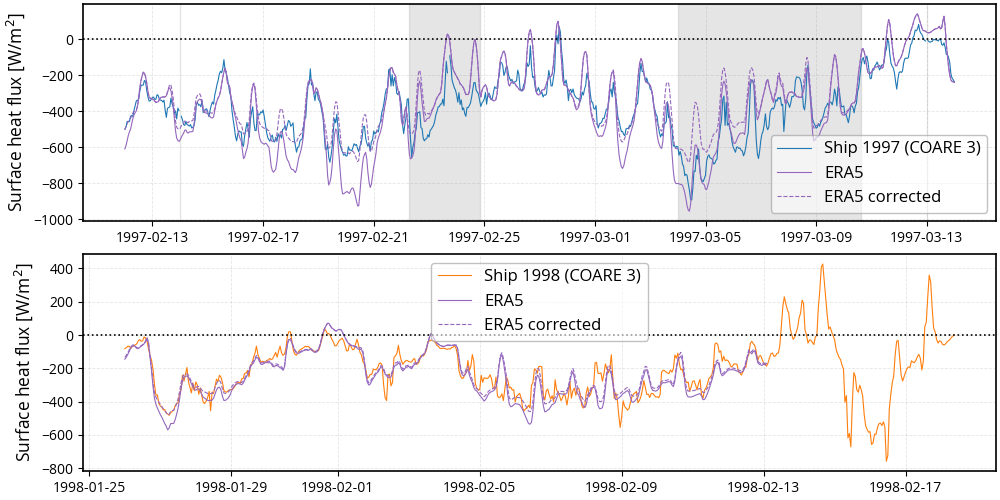

In [20]:
plt.close()
fig = plt.figure(figsize=(10,5), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(spec[0, :])
# ax1.plot(Ship97hr.time, Ship97hr.hf)
ax1.plot(Ship97hr.time, Ship97hr.hfC3, lw=0.8)
ax1.plot(Eship97.time, Eship97.mshf, 'C4', lw=0.8)
ax1.plot(Eship97.time, Eship97.msshf-linear_ft(Eship97.msshf, *pshf97) + \
                       Eship97.mslhf-linear_ft(Eship97.mslhf, *plhf97) + \
                       Eship97.msnswrf + Eship97.msnlwrf, 'C4', ls='--', lw=0.8)
ax1.fill_between(Eship97.time.values, 0, 1, where=~gmask97, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.axhline(0, ls=':', c='k')
ax1.legend(['Ship 1997 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax1.set_ylabel(r'Surface heat flux [W/m$^2$]');

# ax2 = fig.add_subplot(spec[0, 3])
# ax2.scatter(Ship97hr.hf[nearF], Eship97.mshf[nearF], 5, facecolor='none', edgecolors='C0')
# ax2.scatter(Ship97hr.hfC3[nearF], Eship97.mshf[nearF], 5, facecolor='none', edgecolors='C1')
# # ax2.scatter(Ship97hr.hfC3[cice97], Eship97.mshf[cice97], 5, facecolor='none', edgecolors='gray')
# ax2.plot([-1000, 200], [-1000, 200], 'r')
# ax2.axhline(0, ls=':', c='k')
# ax2.axvline(0, ls=':', c='k')
# ax2.set_aspect('equal', 'box')
# ax2.set(xlim=(-1000, 200), ylim=(-1000, 200))
# ax2.set_ylabel('ERA5')
# ax2.set_xlabel('Ship');

ax3 = fig.add_subplot(spec[1, :])
ax3.plot(Ship98hr.time, Ship98hr.hfC3, 'C1', lw=0.8)
ax3.plot(Eship98.time, Eship98.mshf, 'C4', lw=0.8)
ax3.plot(Eship98.time, Eship98.msshf-linear_ft(Eship98.msshf, *pshf98) + \
                       Eship98.mslhf-linear_ft(Eship98.mslhf, *plhf98) + \
                       Eship98.msnswrf + Eship98.msnlwrf, 'C4', ls='--', lw=0.8)
ax3.fill_between(Eship98.time.values, 0, 1, where=~gmask98, color='gray', 
                 alpha=0.2, transform=ax1.get_xaxis_transform())
ax3.axhline(0, ls=':', c='k')
ax3.legend(['Ship 1998 (COARE 3)', 'ERA5', 'ERA5 corrected'])
ax3.set_ylabel(r'Surface heat flux [W/m$^2$]');

#plt.savefig(outfig_dir + 'labsea_hf_compare.png');

#### Correct ERA5 forcing and write flux files

In [27]:
def _prep_labsea_fluxes(fmet, Env, smean, ptau, pshf, plhf, psw, use_correction=True):
    """
    smean: mean near-surface salinity [34.8: SD2002 (Fig. 13), 34.78 SD2004 (Fig. 6)]
    depth for sss and sst is ~ 1 m
    """
    if use_correction:
        nametag = ''
        fmet = fmet.assign(tau=(fmet.mtss-ft_linear(fmet.mtss, *ptau)).assign_attrs(longname='SURFACE STRESS', units='N m-2'))
        fmet = fmet.assign(shf=(fmet.msshf-linear_ft(fmet.msshf, *pshf)).assign_attrs(longname='SENSIBLE HEAT FLUX', units='W m-2'))
        fmet = fmet.assign(lhf=(fmet.mslhf-linear_ft(fmet.mslhf, *plhf)).assign_attrs(longname='LATENT HEAT FLUX', units='W m-2'))
        fmet = fmet.assign(nsw=(fmet.msnswrf/psw).assign_attrs(longname='NET SHORTWAVE RADIATION', units='W m-2'))
    else:
        nametag = 'E'
        fmet = fmet.assign(tau=fmet.mtss.assign_attrs(longname='SURFACE STRESS', units='N m-2'))
        fmet = fmet.assign(shf=fmet.msshf.assign_attrs(longname='SENSIBLE HEAT FLUX', units='W m-2'))
        fmet = fmet.assign(lhf=fmet.mslhf.assign_attrs(longname='LATENT HEAT FLUX', units='W m-2'))
        fmet = fmet.assign(nsw=fmet.msnswrf.assign_attrs(longname='NET SHORTWAVE RADIATION', units='W m-2'))
    taud = np.arctan2(fmet.mntss, fmet.metss)
    fmet = fmet.assign(taux=(fmet.tau*np.cos(taud)).assign_attrs(longname='EASTWARD SURFACE STRESS', units='N m-2'))
    fmet = fmet.assign(tauy=(fmet.tau*np.sin(taud)).assign_attrs(longname='NORTHWARD SURFACE STRESS', units='N m-2'))
    fmet = fmet.assign(sss=xr.full_like(fmet.sst, smean).assign_attrs(longname='SEA SURFACE SALINITY', units='PSU'))
    fmet = fmet.drop_vars(['msthf', 'metss', 'mntss', 'mtss', 'msshf', 'mslhf', 'msnswrf'])
    fmet = fmet.rename({'msnlwrf': 'nlw', 'memp': 'emp'})
    fmet.nlw.attrs.update(longname='NET LONGWAVE RADIATION', units='W m-2')
    fmet.emp.attrs.update(longname='EVAPORATION - PRECIPITATION', units='m/s')
    fmet.sst.attrs.update(longname='SEA SURFACE TEMPERATURE', units='C')
    fmet.sp.attrs.update(longname='AIR PRESSURE', units='Pa')
    # fmet.nswE.attrs.update(longname='ERA5 NET SHORTWAVE RADIATION', units='W m-2')
        
    # thermodynamics
    mlon = Env.lon.mean()
    mlat = Env.lat.mean()
    ssSA  = gsw.SA_from_SP(fmet.sss, 1, mlon, mlat)
    ssCT  = gsw.CT_from_t(ssSA, fmet.sst, 1)
    alpha = gsw.density.alpha(ssSA, ssCT, 1).values
    beta  = gsw.density.beta(ssSA, ssCT, 1).values
    
    fmet = fmet.assign(ustar=np.sqrt(fmet.tau/rho0).assign_attrs(longname='FRICTION VELOCITY', units='m/s'))
    fmet = fmet.assign(ws0=(-fmet.emp*fmet.sss).assign_attrs(longname='KINEMATIC SALT FLUX', units='PSU m/s'))
    
    # Combine heat fluxes
    fmet = fmet.assign(hsrf=(fmet.nlw+fmet.lhf+fmet.shf).assign_attrs(longname='SURFACE HEAT FLUX (NO SW)', units='W m-2'))
    fmet = fmet.assign(hnet=(fmet.nsw+fmet.hsrf).assign_attrs(longname='SURFACE HEAT FLUX', units='W m-2'))
    fmet = fmet.assign(wt0=(-fmet.hsrf/rho0/cp).assign_attrs(longname='KINEMATIC TEMP FLUX (NO SW)', units='C m/s'))

    # Buoyancy fluxes [m^2/s^3]
    fmet = fmet.assign(wb0=(g*(alpha*fmet.wt0-beta*fmet.ws0)).assign_attrs(longname='KINEMATIC BUOY FLUX (NO SW)', units='m2 s-3'))
    fmet = fmet.assign(wbnet_t=(-g*alpha*fmet.hnet/rho0/cp).assign_attrs(longname='KINEMATIC BUOY FLUX (T PART)', units='m2 s-3'))
    fmet = fmet.assign(wbnet_s=(-g*beta*fmet.ws0).assign_attrs(longname='KINEMATIC BUOY FLUX (S PART)', units='m2 s-3'))
    fmet = fmet.assign(wbnet=(fmet.wbnet_t+fmet.wbnet_s).assign_attrs(longname='KINEMATIC BUOY FLUX', units='m2 s-3'))
    
    fmet.attrs.update(description='Surface fluxes at float position and time, interpolated from ERA5 reanalysis')
    year = np.unique(fmet.time.dt.year)[0]
    nc_name = 'LabSea_fluxes_' + str(year) + nametag + '.nc'
    fmet.to_netcdf(flux_dir + nc_name, engine='netcdf4')
    print(f'Air-sea fluxes: {nc_name} saved at {flux_dir}.\n')
    return fmet

In [35]:
fmet97lux = _prep_labsea_fluxes(fmet97, Env97, 34.8, ptau97, pshf97, plhf97, psw97)
fmet97luxE = _prep_labsea_fluxes(fmet97, Env97, 34.8, ptau97, pshf97, plhf97, psw97, use_correction=False)
fmet98lux = _prep_labsea_fluxes(fmet98, Env98, 34.78, [0,0], [0,0], [0,0], 1)

Air-sea fluxes: LabSea_fluxes_1997.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/LabSea/Met/.

Air-sea fluxes: LabSea_fluxes_1997E.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/LabSea/Met/.

Air-sea fluxes: LabSea_fluxes_1998.nc saved at /media/zhihua/internal1/GDrive/UW/Research/Data/LabSea/Met/.



In [45]:
2*gsw.density.alpha(34.8, fmet97lux.sst.mean('ID').mean(), 1)/(gsw.density.alpha(34.8, fmet97lux.sst.mean('ID').mean(), 2)-gsw.density.alpha(34.8, fmet97lux.sst.mean('ID').mean(), 0))

<xarray.DataArray 'sst' ()>
array(3205.49604025)

In [48]:
823/3205/3

0.08559542381695268

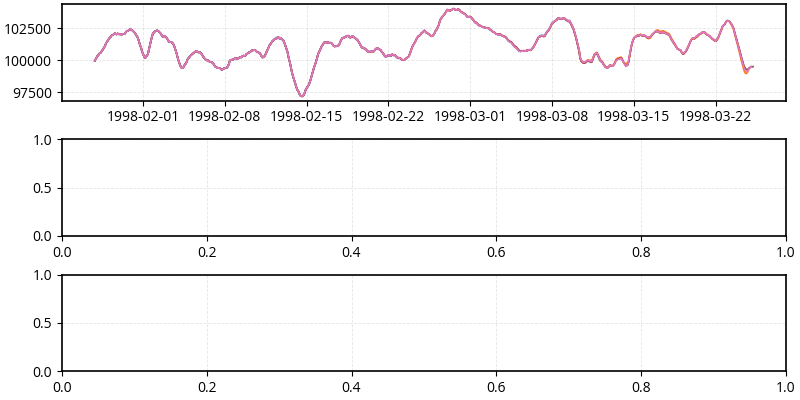

In [56]:
plt.close()
_,ax = plt.subplots(3,1, figsize=(8,4), constrained_layout=True)

# ax[0].plot(fmet98lux.time, fmet98lux.tau.T, c='C0')
# ax[0].plot(fmet97lux.time, fmet97luxE.tau.T, c='C1');

# ax[1].plot(fmet97lux.time, fmet97lux.shf.T)#, c='C0')
# ax[1].plot(fmet97lux.time, fmet97luxE.shf.T, c='C1');

# ax[2].plot(fmet97lux.time, fmet97lux.lhf.T)#, c='C0')
# ax[2].plot(fmet97lux.time, fmet97luxE.lhf.T, c='C1');

In [6]:
from matplotlib.patches import Rectangle, ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker

def _annotate(ax, x, y):
    X, Y = np.meshgrid(x, y)
    ax.plot(X.flat, Y.flat, '.', color='w', ms=0.7, transform=ccrs.PlateCarree())

def coordXform(orig_crs, target_crs, x, y):
    xyzr = target_crs.transform_points(orig_crs, x, y)
    return xyzr#[:,0], xyzr[:,1]

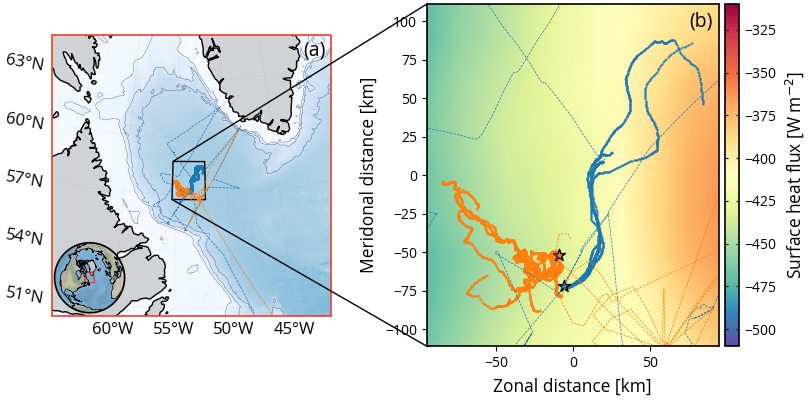

In [12]:
plt.close()
fig = plt.figure(figsize=(8.1,4), constrained_layout=True)
spec = fig.add_gridspec(1, 8)

MAPEXTENT = (-65,-42,50,65) # (-61.5,-48.1,52.75,61.1)
# projPC = ccrs.PlateCarree(central_longitude=(MAPEXTENT[0]+MAPEXTENT[1])/2)
projOG = ccrs.Orthographic(central_longitude=-53.5, 
                           central_latitude=57.5)
projNP = ccrs.NearsidePerspective(central_longitude=-53.5, 
                                  central_latitude=57.5)

ax1 = fig.add_subplot(spec[:,:3], projection=projOG)
# Get slice of ETOPO2 topography data from WHOI's GEOPORT thredds server
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo2_v2c.nc'
bathy = xr.open_dataset(url)
bathy = bathy.sel(lon=slice(MAPEXTENT[0]-10,MAPEXTENT[1]+10),
                  lat=slice(MAPEXTENT[2]-2,MAPEXTENT[3]+2))
plt.rcParams['axes.grid'] = False
ax1.pcolormesh(bathy.lon, bathy.lat, bathy.topo, vmin=-10000, vmax=0, cmap='Blues_r',
              shading='auto', transform=ccrs.PlateCarree())
ax1.contour(bathy.lon, bathy.lat, bathy.topo, levels=[-2500, -1500, -500], 
           colors='xkcd:marine', linestyles='-', linewidths=0.2, transform=ccrs.PlateCarree())
ax1.set_extent(MAPEXTENT)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                edgecolor='k', facecolor=[0.2, 0.2, 0.2, 0.2]))
gl = ax1.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -55, -50, -45])
gl.ylocator = mticker.FixedLocator([51, 54, 57, 60, 63])
gl.ylabel_style = {'rotation': -10}

# _annotate(ax, ERA5.lon, ERA5.lat)
# plt.pcolormesh(ERA5.lon, ERA5.lat, 
#                ERA5.siconc.sel(time='1998-02-28 11:30:00'),
#                transform=ccrs.PlateCarree(), cmap='Blues_r', vmin=0, vmax=1, shading='gouraud');
# plt.streamplot(ERA5.lon, ERA5.lat, 
#            ERA5.u10.sel(time='1997-02-28 11:30:00').values,ERA5.u10.sel(time='1997-02-28 11:30:00').values, 
#            transform=ccrs.PlateCarree());


ax1.plot(Ship97hr.lon.interp(time=Env97.timePOS), 
        Ship97hr.lat.interp(time=Env97.timePOS), lw=0.5, ls='--', c='C0', transform=ccrs.PlateCarree());
ax1.plot(Ship98hr.lon.interp(time=Env98.timePOS), 
        Ship98hr.lat.interp(time=Env98.timePOS), lw=0.5, ls='--', c='C1', transform=ccrs.PlateCarree());
# ax.scatter(Ship98hr.lon, Ship98hr.lat, 2, (Eship98.wspd10-Ship98hr.wspd10), transform=ccrs.PlateCarree(), cmap='bwr_r');
# ax.scatter(Ship98hr.lon.sel(time=slice('1998-02-08 19:00:00','1998-02-10 01:00:00')), 
#            Ship98hr.lat.sel(time=slice('1998-02-08 19:00:00','1998-02-10 01:00:00')), 5, 'w', 'd', transform=ccrs.PlateCarree());

ax1.scatter(Env97.lon, Env97.lat, 2, 'C0', '.', transform=ccrs.PlateCarree());
ax1.scatter(Env98.lon, Env98.lat, 2, 'C1', '.', transform=ccrs.PlateCarree());

# ax.scatter(Env97.lon, Env97.lat, 2, np.tile(Env97.ID.values[:,None], (1,Env97.dims['timePOS'])), '.',
#            transform=ccrs.PlateCarree(), cmap='Dark2');
# ax.scatter(Env98.lon, Env98.lat, 2, np.tile(Env98.ID.values[:,None], (1,Env98.dims['timePOS'])), '.',
#            transform=ccrs.PlateCarree(), cmap='Dark2');
ax1.add_patch(Rectangle((ElonMin, ElatMin), hdlon*2, hdlat*2, linewidth=1, 
                        facecolor='none', edgecolor='k', transform=ccrs.PlateCarree()))
ax1.text(0.98, 0.98, '(a)', fontsize=14, ha='right', va='top', transform=ax1.transAxes)

for spine in ax1.spines.values():
        spine.set_edgecolor('xkcd:tomato')

axin = inset_axes(ax1, width=0.7, height=0.7, bbox_to_anchor=(0.01, 0.01), loc='lower left',
                  bbox_transform=ax1.transAxes, axes_class=cmpl.geoaxes.GeoAxes, 
                  borderpad=0, axes_kwargs=dict(map_projection=projNP))
axin.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m',
                 edgecolor='k', linewidth=0.5, facecolor=[0.2, 0.2, 0.2, 0.2]))
axin.stock_img()
axin.set_global()
axin.add_patch(Rectangle((MAPEXTENT[0], MAPEXTENT[2]), MAPEXTENT[1]-MAPEXTENT[0], MAPEXTENT[3]-MAPEXTENT[2], linewidth=1, 
                        facecolor='none', edgecolor='xkcd:tomato', transform=ccrs.PlateCarree()))


ax2 = fig.add_subplot(spec[:,3:])
pmTHF = ax2.pcolormesh((ERA5.lon-ElonC)*111*np.cos(ElatC*pi/180), (ERA5.lat-ElatC)*111, 
                ERA5.sel(time='1997').mshf.groupby(ERA5.sel(time='1997').time.dt.month).mean().sel(month=2),
                cmap='Spectral_r', vmin=-510, vmax=-310, shading='gouraud');
cax = inset_axes(ax2,
                 width='5%', 
                 height='100%',
                 loc='lower left',
                 bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax2.transAxes,
                 borderpad=0)
fig.colorbar(pmTHF, ax=ax2, cax=cax, label=r'Surface heat flux [W m$^{-2}$]')
cax.tick_params(axis='y', direction='in', length=2, 
                labelleft=False, labelright=True, left=True, right=True)

ax2.scatter((Env97.lon-ElonC)*111*np.cos(ElatC*pi/180), (Env97.lat-ElatC)*111, 1, 'C0', '.');
ax2.scatter((Env98.lon-ElonC)*111*np.cos(ElatC*pi/180), (Env98.lat-ElatC)*111, 1, 'C1', '.');
ax2.plot((Ship97hr.lon.interp(time=Env97.timePOS)-ElonC)*111*np.cos(ElatC*pi/180), 
         (Ship97hr.lat.interp(time=Env97.timePOS)-ElatC)*111, lw=0.5, ls='--', c='C0')
ax2.plot((Ship98hr.lon.interp(time=Env98.timePOS)-ElonC)*111*np.cos(ElatC*pi/180), 
         (Ship98hr.lat.interp(time=Env98.timePOS)-ElatC)*111, lw=0.5, ls='--', c='C1')
ax2.scatter((Env97.lon[:,0].mean()-ElonC)*111*np.cos(ElatC*pi/180), (Env97.lat[:,0].mean()-ElatC)*111, 80, 
            facecolor='C0', edgecolors='k', marker='*')
ax2.scatter((Env98.lon[:,0].mean()-ElonC)*111*np.cos(ElatC*pi/180), (Env98.lat[:,0].mean()-ElatC)*111, 80, 
            facecolor='C1', edgecolors='k', marker='*')
ax2.set_xlim(-hdlon*111*np.cos(ElatC*pi/180), 
              hdlon*111*np.cos(ElatC*pi/180))
ax2.set_ylim(-hdlat*111, hdlat*111)
ax2.text(0.98, 0.98, '(b)', fontsize=14, ha='right', va='top', transform=ax2.transAxes)
ax2.set_aspect(aspect=1)
ax2.set_xlabel('Zonal distance [km]')
ax2.set_ylabel('Meridonal distance [km]')

con1 = ConnectionPatch(xyA=projOG.transform_point(ElonMin, ElatMin, ccrs.PlateCarree()), coordsA=ax1.transData, 
                       xyB=(-hdlon*111*np.cos(ElatC*pi/180), -hdlat*111), coordsB=ax2.transData)
con2 = ConnectionPatch(xyA=projOG.transform_point(ElonMin, ElatMax, ccrs.PlateCarree()), coordsA=ax1.transData, 
                       xyB=(-hdlon*111*np.cos(ElatC*pi/180), hdlat*111), coordsB=ax2.transData)
fig.add_artist(con1)
fig.add_artist(con2);
plt.rcParams['axes.grid'] = True;

plt.savefig(outfig_dir + 'Labsea_map.png');